# Nanostring heatmap

**Goal:**

Make a publication style figure from normalized Nanostring data + calculate average pseudotime

Steps:  
1) Read in Nanostring normalized raw .csv file    
2) Make new file where calculate average   
3) Subset with selected gene list (selected_genes_curated.csv)   
4) Hierarchical clustering on the rows + plotting row z-score using seaborn.clustermap function  


5) read in list of pseudotimes and calculate avg and stdv

ran this notebook with the docker container
866995796105.dkr.ecr.us-east-2.amazonaws.com/scrna:python-3.7-20191025

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 

from gprofiler import GProfiler
import re

from tempfile import NamedTemporaryFile
#import urllib3
import urllib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

### 1) Read in Nanostring normalized raw .csv file

In [2]:
raw_df = pd.read_csv('NormalizedData_cleaned_including_invivo_humanKidney.csv', index_col = 0)

In [3]:
raw_df.head()

,D0_1,D0_2,D7_1,D7_2,D7_3,D10_1,D10_2,D10_3,D10_4,D12_1,...,D12_4w_2,D12_4w_3,D12_4w_4,D14_4w_1,D14_4w_2,D14_4w_3,fetal Kidney_0,adult Kidney_1,adult Kidney_2,5 Kidney pool_0
ABCF1,1376.21,1159.33,708.61,866.54,838.38,1005.07,1122.40,1123.16,818.48,867.17,...,534.25,727.65,658.87,393.92,699.33,610.73,691.02,796.95,794.45,928.13
ACAT2,2268.63,6394.35,2223.62,860.36,1003.27,2041.08,2210.22,4758.33,5121.65,5543.62,...,395.20,514.15,621.01,391.52,490.43,380.33,497.82,558.57,475.94,751.71
ACE,12.29,22.40,1.00,2.39,1.00,2.32,1.97,4.58,4.79,1.00,...,180.57,93.08,202.74,194.33,179.47,152.00,443.48,88.15,602.72,605.76
ACTA2,2.89,13.58,788.81,636.92,648.59,105.68,78.01,93.71,91.13,105.70,...,5252.95,3821.43,4518.86,8050.72,8615.24,4637.56,6132.05,6087.48,3671.83,3430.08
ACTG2,119.29,146.71,13.44,10.34,6.79,8.26,1.97,6.85,4.79,1.00,...,791.19,1293.03,687.72,1334.19,1367.50,587.90,581.13,569.69,253.29,386.04


### 2) manually calculate the average of the replicates

In [4]:
col_names =  ['D0', 'D7', 'D10', 'D12', 'D14', 'D24', 'D26', 'D28', 'D10_2w', 'D12_2w', 'D14_2w', 'D10_4w', 'D12_4w', 'D14_4w', 'Fetal_Kidney', 'Adult_Kidney']
avg_df  = pd.DataFrame(columns = col_names)

avg_df['D0'] = raw_df[['D0_1','D0_2']].mean(axis=1, skipna=True)
avg_df['D7'] = raw_df[['D7_1','D7_2','D7_3']].mean(axis=1, skipna=True)
avg_df['D10'] = raw_df[['D10_1','D10_2','D10_3','D10_4']].mean(axis=1, skipna=True)
avg_df['D12'] = raw_df[['D12_1','D12_2','D12_3','D12_4']].mean(axis=1, skipna=True)
avg_df['D14'] = raw_df[['D14_1','D14_2','D14_3']].mean(axis=1, skipna=True)
avg_df['D24'] = raw_df[['D24_1','D24_2','D24_3']].mean(axis=1, skipna=True)
avg_df['D26'] = raw_df[['D26_1','D26_2','D26_3','D26_4']].mean(axis=1, skipna=True)
avg_df['D28'] = raw_df[['D28_1','D28_2','D28_3']].mean(axis=1, skipna=True)
avg_df['D10_2w'] = raw_df[['D10_2w_1','D10_2w_2']].mean(axis=1, skipna=True)
avg_df['D12_2w'] = raw_df[['D12_2w_1','D12_2w_2', 'D12_2w_3']].mean(axis=1, skipna=True)
avg_df['D14_2w'] = raw_df[['D14_2w_1','D14_2w_2', 'D14_2w_3', 'D14_2w_4', 'D14_2w_5','D14_2w_6', 'D14_2w_7', 'D14_2w_8', 'D14_2w_9']].mean(axis=1, skipna=True)
avg_df['D10_4w'] = raw_df[['D10_4w_1','D10_4w_2', 'D10_4w_3']].mean(axis=1, skipna=True)
avg_df['D12_4w'] = raw_df[['D12_4w_1','D12_4w_2', 'D12_4w_3', 'D12_4w_4']].mean(axis=1, skipna=True)
avg_df['D14_4w'] = raw_df[['D14_4w_1','D14_4w_2', 'D14_4w_3']].mean(axis=1, skipna=True)
avg_df['Fetal_Kidney'] = raw_df[['fetal Kidney_0']]
avg_df['Adult_Kidney'] = raw_df[['adult Kidney_1','adult Kidney_2']].mean(axis=1, skipna=True)


avg_df.head()

,D0,D7,D10,D12,D14,D24,D26,D28,D10_2w,D12_2w,D14_2w,D10_4w,D12_4w,D14_4w,Fetal_Kidney,Adult_Kidney
ABCF1,1267.770,804.510000,1017.2775,900.3825,799.220000,777.133333,724.8175,716.386667,941.075,729.786667,768.522222,678.860000,665.3775,567.993333,691.02,795.700
ACAT2,4331.490,1362.416667,3532.8200,4231.9175,4019.343333,1027.453333,884.5025,848.033333,469.710,600.106667,459.236667,527.270000,456.8575,420.760000,497.82,517.255
ACE,17.345,1.463333,3.4150,2.1850,6.566667,26.070000,27.4475,36.046667,2.330,115.940000,146.575556,83.270000,157.3525,175.266667,443.48,345.435
ACTA2,8.235,691.440000,92.1325,95.6300,139.680000,231.343333,246.6850,268.416667,5977.760,6430.370000,3071.598889,3873.603333,4263.4000,7101.173333,6132.05,4879.655
ACTG2,133.000,10.190000,5.4675,2.6875,6.240000,5.470000,10.4900,17.736667,429.125,628.770000,413.114444,483.910000,906.9800,1096.530000,581.13,411.490


### 3) Plot full heatmap

In [5]:
outfile = "./figures_nov20/"

#### **generate ordered list to split clustered heatmap**

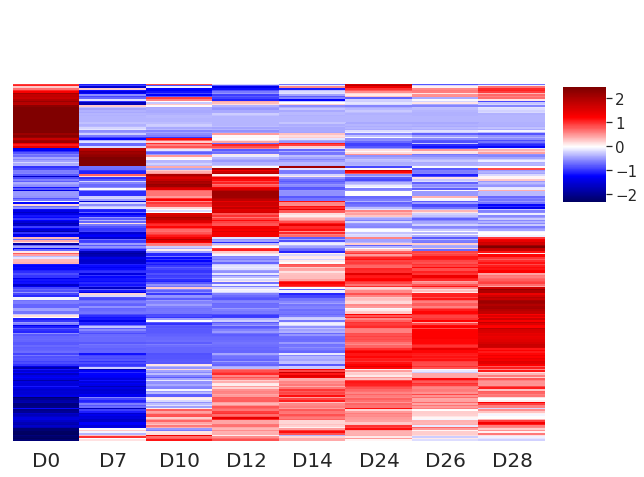

In [6]:
# Averaged

sns_plot = sns.clustermap(avg_df.iloc[:,0:8], 
                    col_cluster=False, 
                    row_cluster=True, 
                    cmap = 'seismic', 
                    figsize= (12, 8),
                    z_score=0, 
                    annot=False, 
                    yticklabels=False,
                    center = 0,
                    cbar=True)


sns_plot.ax_row_dendrogram.set_visible(False)

# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
sns_plot.cax.set_position([.92, .54, .05, .20])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=15) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 16 ,style ="italic", rotation=45)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 20)  # For x axis

plt.show()

In [7]:
# this generates a list of genes ordered by the clustering

genes_df = pd.DataFrame(avg_df.index.tolist())
genes_df['index1'] = genes_df.index
neworder_df = pd.DataFrame(sns_plot.dendrogram_row.reordered_ind, columns = ['index1'])
orderedbycluster = pd.merge(neworder_df, genes_df, how='inner', on='index1')
orderedbycluster = orderedbycluster.rename(columns={0: 'gene'})

In [8]:
# make a new df with the genes ordered with this clustering (so does not need to be clustered before plotting)

avg_df_neworder = pd.merge(avg_df, orderedbycluster, how='right', left_index= True, right_on='gene')
avg_df_neworder = avg_df_neworder.set_index(['gene'])
avg_df_neworder = avg_df_neworder.drop(['index1'], axis=1)

#delete index header
del avg_df_neworder.index.name

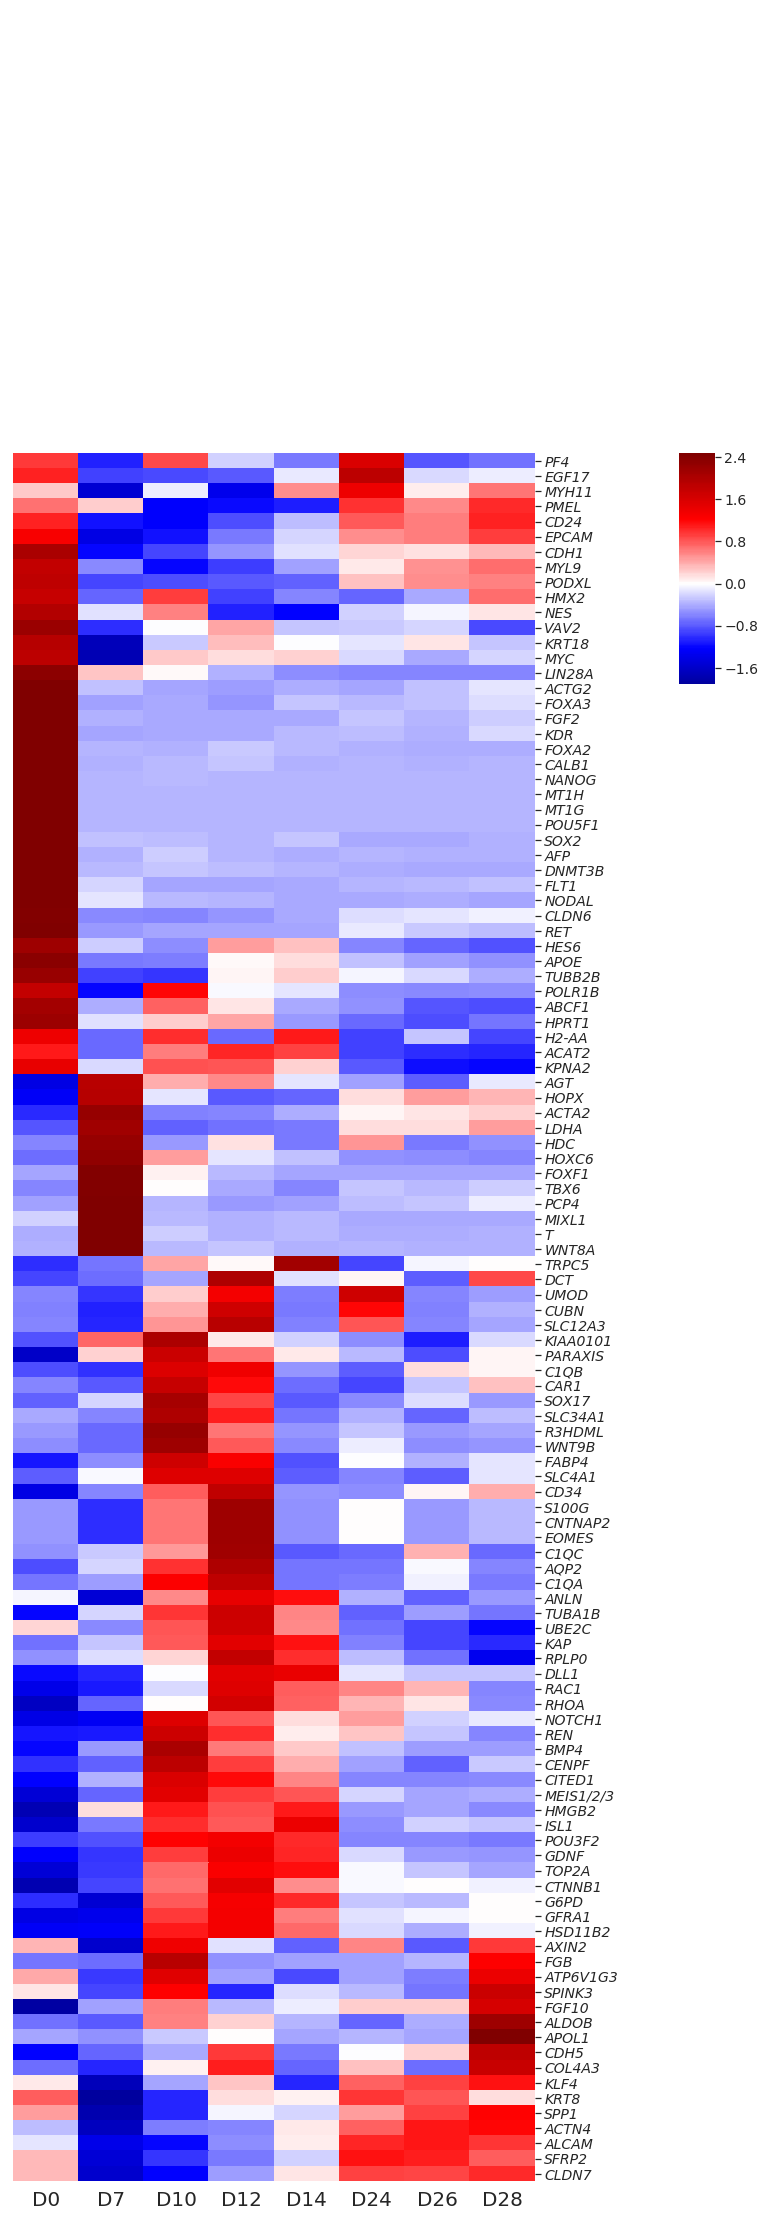

In [9]:
# plot first part of the heatmap

sns_plot = sns.clustermap(avg_df_neworder.iloc[0:114,0:8], 
                        col_cluster=False, 
                        row_cluster=False, 
                        cmap = 'seismic', 
                        figsize= (10, 40),
                        z_score=0,
                        center = 0,
                        annot=False, 
                        yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(False)
#sns_plot.cax.set_visible(False)


# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
sns_plot.cax.set_position([1.1, .645, .05, .08])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=14) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 14 ,style ="italic")  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 20)  # For y axis

plt.show()

In [10]:
sns_plot.savefig("all_genes_long_part1.pdf", dpi=300)

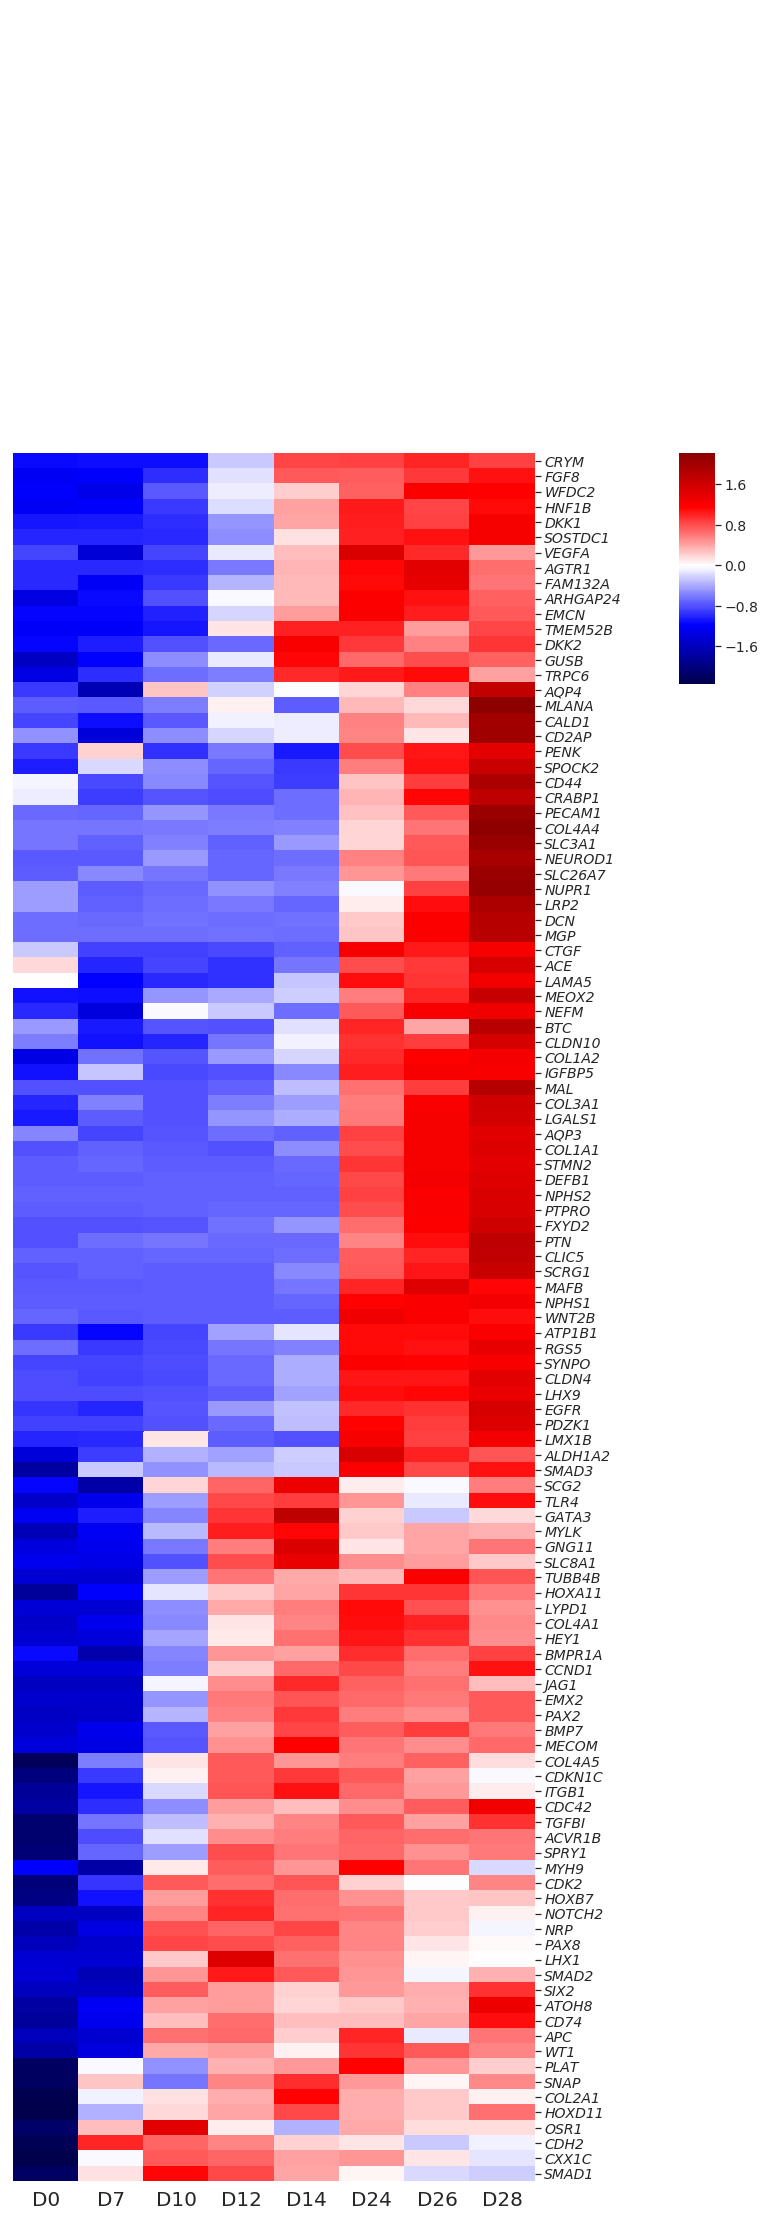

In [11]:
sns_plot = sns.clustermap(avg_df_neworder.iloc[115:,0:8], 
                        col_cluster=False, 
                        row_cluster=False, 
                        cmap = 'seismic', 
                        figsize= (10, 40),
                        z_score=0,
                        center = 0,
                        annot=False, 
                        yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(False)

# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
sns_plot.cax.set_position([1.1, .645, .05, .08])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=14) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 14 ,style ="italic")  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 20)  # For y axis
plt.show()

In [12]:
sns_plot.savefig("all_genes_long_part2.pdf", dpi=300)

### with different fonts

In [13]:
# font normal 
github_url = 'https://github.com/google/fonts/blob/9409aff0417ff2e6e66c40c673339214185251d4/apache/roboto/Roboto%5Bwdth%2Cwght%5D.ttf'

url = github_url + '?raw=true'  # You want the actual file, not some html

#response = urllib3.request.urlopen(url)
response = urllib.request.urlopen(url)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()

# font italic
github_url = 'https://github.com/google/fonts/blob/9409aff0417ff2e6e66c40c673339214185251d4/apache/roboto/Roboto-Italic%5Bwdth%2Cwght%5D.ttf'

url = github_url + '?raw=true'  # You want the actual file, not some html

#response = urllib3.request.urlopen(url)
response = urllib.request.urlopen(url)
g = NamedTemporaryFile(delete=False, suffix='.ttf')
g.write(response.read())
g.close()


prop_g = fm.FontProperties(fname=g.name, size = 14)
prop_l = fm.FontProperties(fname=f.name, size = 14)
prop_f = fm.FontProperties(fname=f.name, size = 20)

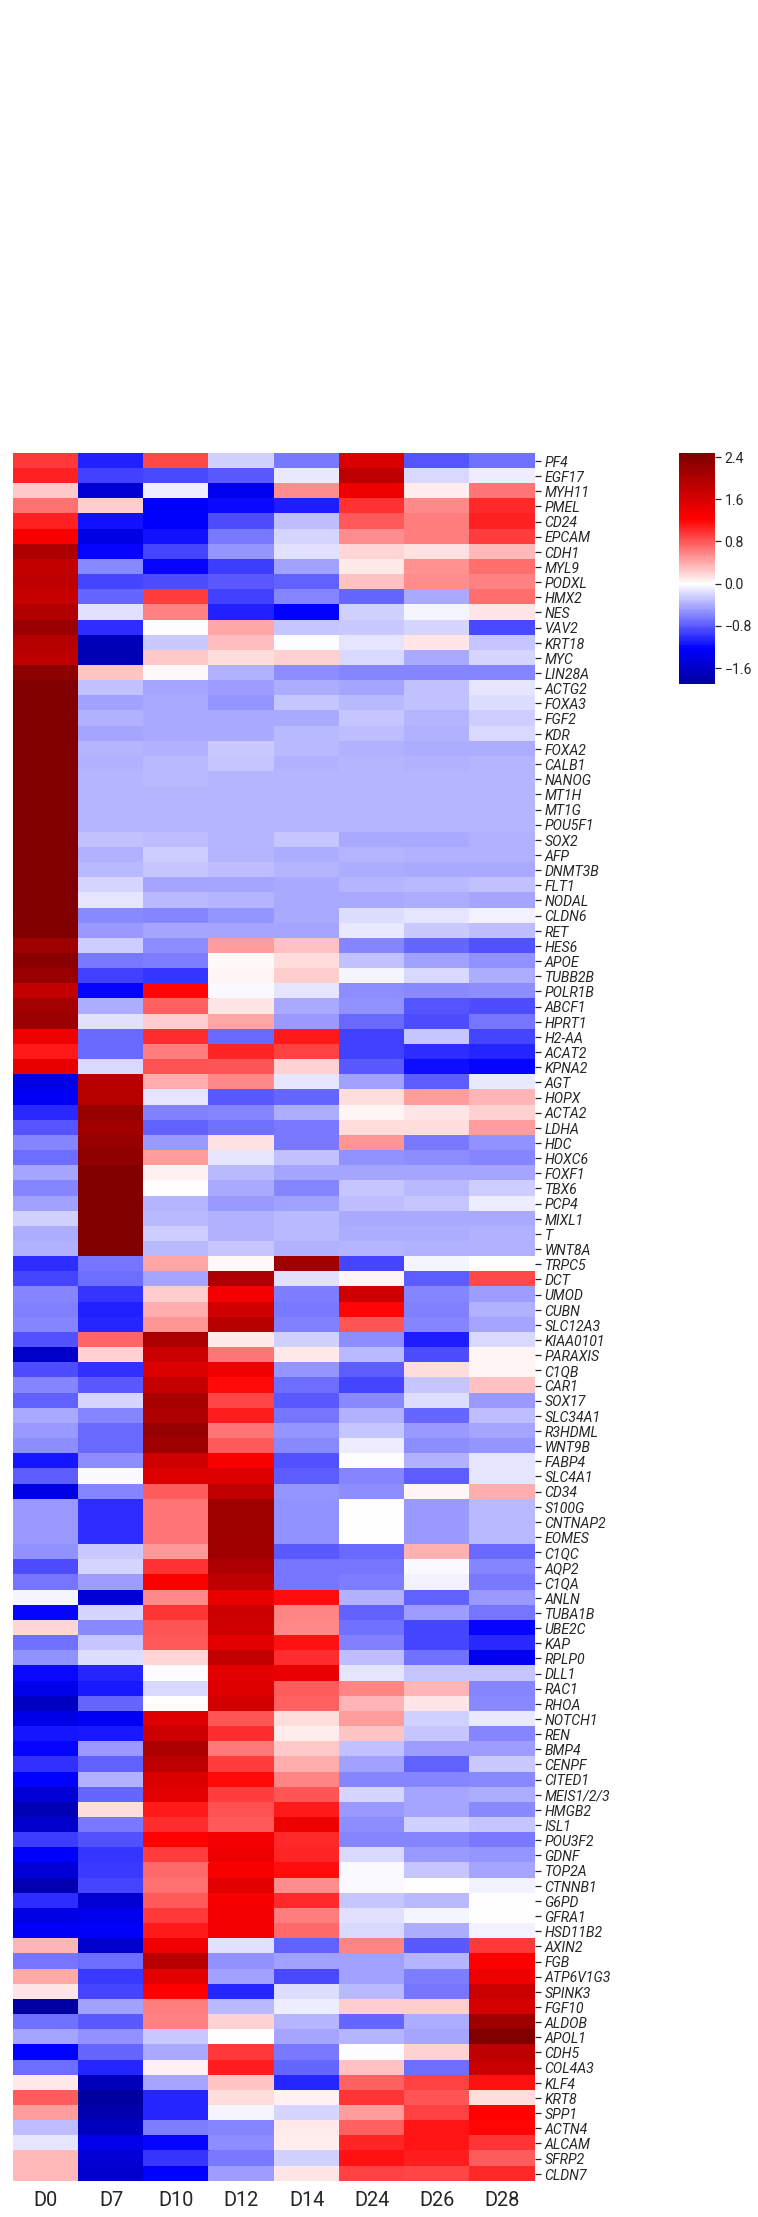

In [14]:
sns_plot = sns.clustermap(avg_df_neworder.iloc[0:114,0:8], 
                        col_cluster=False, 
                        row_cluster=False, 
                        cmap = 'seismic', 
                        figsize= (10, 40),
                        z_score=0,
                        center = 0,
                        #annot=False, 
                        yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(False)
#sns_plot.cax.set_visible(False)


# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
sns_plot.cax.set_position([1.1, .645, .05, .08])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontproperties=prop_l) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontproperties=prop_g)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontproperties=prop_f)  # For y axis

plt.show()

In [15]:
sns_plot.savefig("all_genes_long_part1_roboto.pdf", dpi=300)

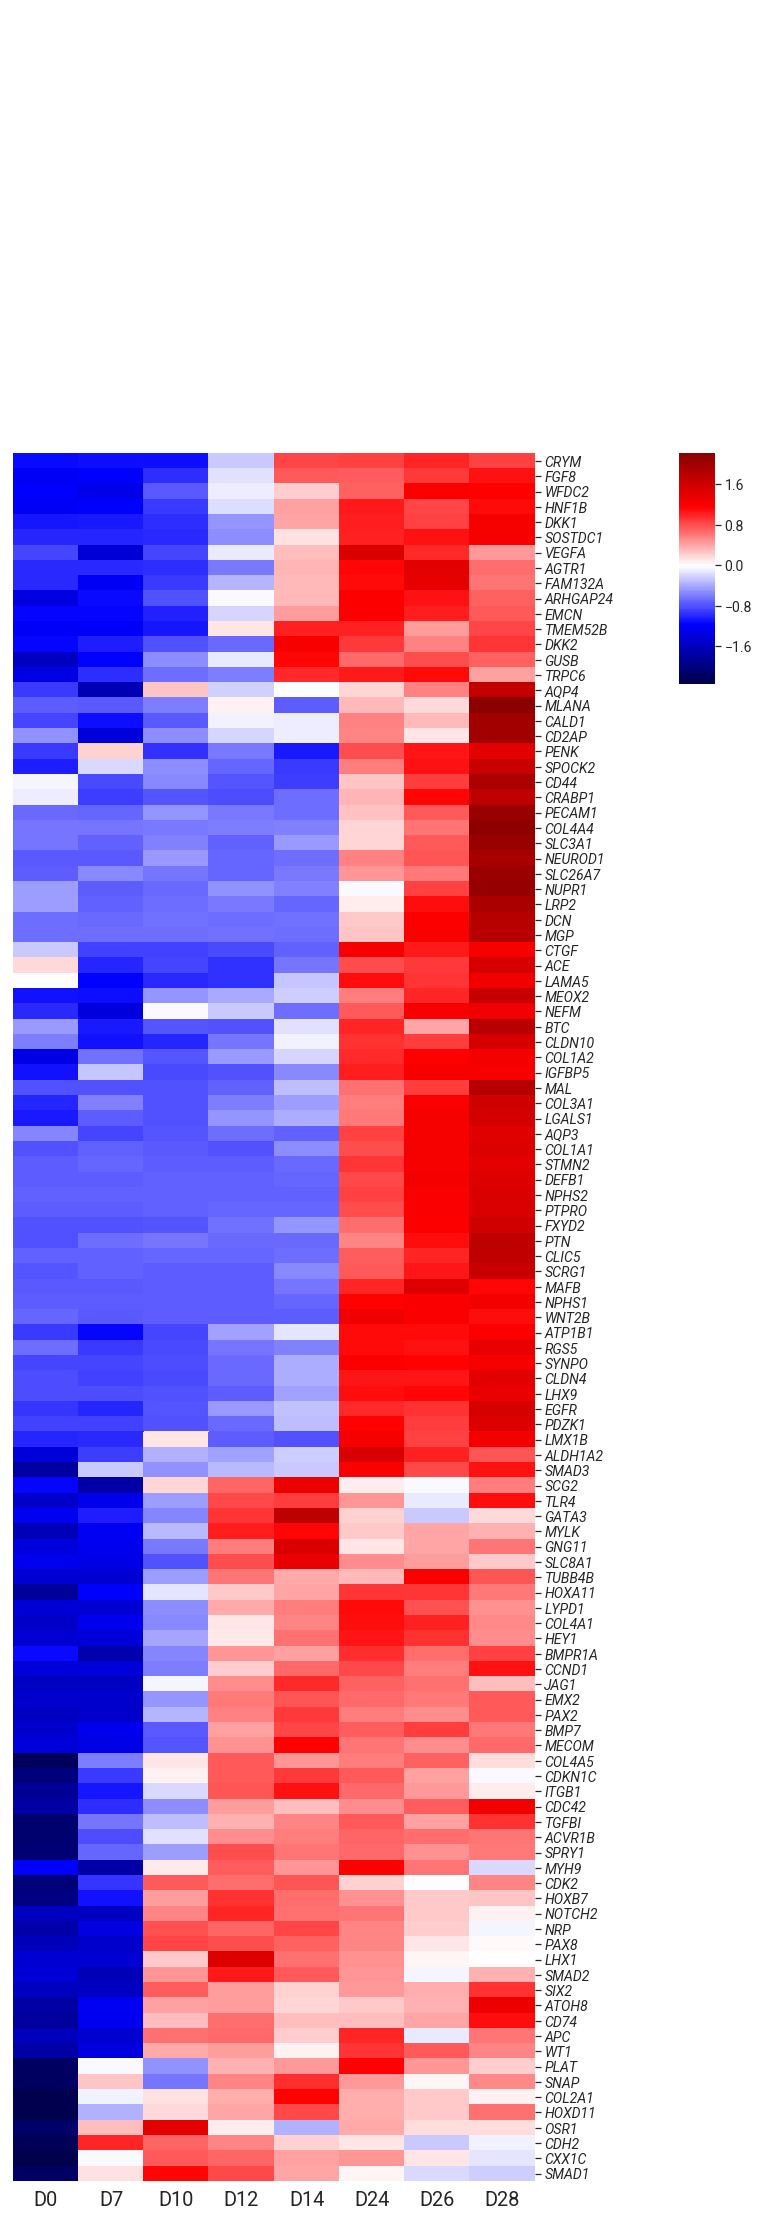

In [16]:
sns_plot = sns.clustermap(avg_df_neworder.iloc[115:,0:8], 
                        col_cluster=False, 
                        row_cluster=False, 
                        cmap = 'seismic', 
                        figsize= (10, 40),
                        z_score=0,
                        center = 0,
                        #annot=False, 
                        yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(False)
#sns_plot.cax.set_visible(False)


# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
sns_plot.cax.set_position([1.1, .645, .05, .08])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontproperties=prop_l) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontproperties=prop_g)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontproperties=prop_f)  # For y axis

plt.show()


In [17]:
sns_plot.savefig("all_genes_long_part2_roboto.pdf", dpi=300)

### 4) Subset with selected gene list

In [18]:
select_genes = pd.read_csv('selected_genes_oct20.csv', index_col = 0)

In [19]:
avg_df_select = pd.merge(avg_df, select_genes, how='right', left_index= True, right_on='gene')

#delete index header
del avg_df_select.index.name

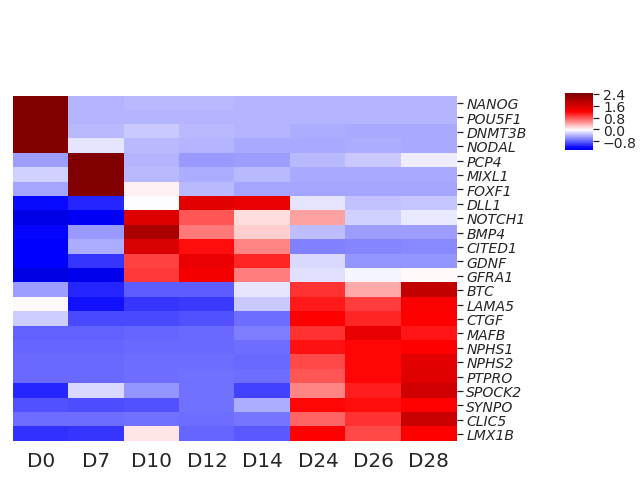

In [20]:
sns_plot = sns.clustermap(avg_df_select.iloc[:,0:8], 
                        col_cluster=False, 
                        row_cluster=False, 
                        cmap = 'seismic', 
                        figsize= (10, 8),
                        z_score=0,
                        center = 0,
                        #annot=False, 
                        yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(False)
#sns_plot.cax.set_visible(False)

# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
sns_plot.cax.set_position([1.05, .63, .04, .1])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=14) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 14 , style ="italic")  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 20)  # For y axis
plt.show()


In [21]:
sns_plot.savefig("selected_genes.pdf", dpi=300)

In [22]:
# font normal 
github_url = 'https://github.com/google/fonts/blob/9409aff0417ff2e6e66c40c673339214185251d4/apache/roboto/Roboto%5Bwdth%2Cwght%5D.ttf'

url = github_url + '?raw=true'  # You want the actual file, not some html

#response = urllib3.request.urlopen(url)
response = urllib.request.urlopen(url)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()

# font italic
github_url = 'https://github.com/google/fonts/blob/9409aff0417ff2e6e66c40c673339214185251d4/apache/roboto/Roboto-Italic%5Bwdth%2Cwght%5D.ttf'

url = github_url + '?raw=true'  # You want the actual file, not some html

#response = urllib3.request.urlopen(url)
response = urllib.request.urlopen(url)
g = NamedTemporaryFile(delete=False, suffix='.ttf')
g.write(response.read())
g.close()


prop_g = fm.FontProperties(fname=g.name, size = 14)
prop_l = fm.FontProperties(fname=f.name, size = 14)
prop_f = fm.FontProperties(fname=f.name, size = 20)

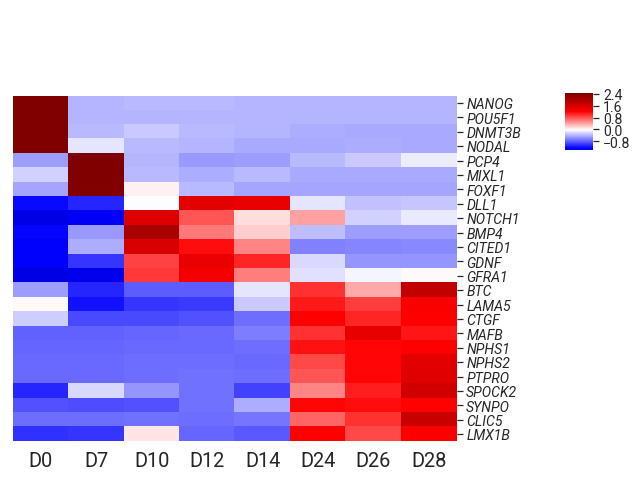

In [23]:
sns_plot = sns.clustermap(avg_df_select.iloc[:,0:8], 
                        col_cluster=False, 
                        row_cluster=False, 
                        cmap = 'seismic', 
                        figsize= (10, 8),
                        z_score=0,
                        center = 0,
                        #annot=False, 
                        yticklabels=True)

sns_plot.ax_row_dendrogram.set_visible(False)
#sns_plot.cax.set_visible(False)

# moves the color bar and changes the font size
#[distance horizontal, distance vertical, width horizontal, width vertical]
sns_plot.cax.set_position([1.05, .63, .04, .1])
plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=14, fontproperties=prop_l) 

plt.setp(sns_plot.ax_heatmap.get_yticklabels(), fontsize = 14 , style ="italic", fontproperties=prop_g)  # For y axis
plt.setp(sns_plot.ax_heatmap.get_xticklabels(), fontsize = 14,  fontproperties=prop_f)  # For y axis
plt.show()


In [24]:
sns_plot.savefig("selected_genes_roboto.pdf", dpi=300)

### 5) Calculate Pseudotime

In [25]:
# to annotate by week and day
def annotate_df(df):

    # extract conditions
    week_list = []
    day_list = []

    for index, row in df.iterrows():
        week = 0
        day = 0
        if len(index.split('-'))> 1:
            week = str(index.split('-')[1]) 
        if len(index.split('-'))> 1:
            day = str(index.split('-')[0]) 
       
        week_list.append(week)
        day_list.append(day)
    df['week'] = week_list
    df['day'] = day_list
    
    return df

In [26]:
podo = pd.read_csv('pseudotime_podocytes.csv', index_col = 0)
podo['stage']=podo.index
podo = annotate_df(podo)
podo.head()

,cell_type_manual_factor,Pseudotime,stage,week,day
condition2,,,,,
Adult Kidney,Podocyte,23.790083,Adult Kidney,0,0
Adult Kidney,Podocyte,18.659348,Adult Kidney,0,0
Adult Kidney,Podocyte,17.513058,Adult Kidney,0,0
Adult Kidney,Podocyte,4.691989,Adult Kidney,0,0
Adult Kidney,Podocyte,23.373061,Adult Kidney,0,0


In [27]:
podo['stage'].value_counts()

D10-2wk         3702
D10-4wk         2062
D12-4wk         1905
D12-2wk         1505
D14-2wk          912
D14-4wk          667
Fetal Kidney     365
Adult Kidney     198
Name: stage, dtype: int64

In [28]:
podo.groupby(['stage']).mean()

,Pseudotime
stage,
Adult Kidney,18.846649
D10-2wk,15.468599
D10-4wk,18.394682
D12-2wk,17.934587
D12-4wk,17.391238
D14-2wk,21.253829
D14-4wk,20.404847
Fetal Kidney,20.654802


In [29]:
podo.groupby(['stage']).std()

,Pseudotime
stage,
Adult Kidney,4.551793
D10-2wk,6.885614
D10-4wk,4.952198
D12-2wk,5.179086
D12-4wk,6.312876
D14-2wk,3.151861
D14-4wk,4.369047
Fetal Kidney,3.775800


In [30]:
podo.groupby(['week']).mean()

,Pseudotime
week,
0,20.018897
2wk,16.937375
4wk,18.271510


In [31]:
podo.groupby(['week']).std()

,Pseudotime
week,
0,4.152501
2wk,6.409497
4wk,5.568859


In [32]:
podo.groupby(['day']).mean()

,Pseudotime
day,
0,20.018897
D10,16.515369
D12,17.631045
D14,20.895203


In [33]:
podo.groupby(['day']).std()

,Pseudotime
day,
0,4.152501
D10,6.417621
D12,5.845094
D14,3.737315
